In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import sys; sys.path.insert(1, '/home/matteo/Eureca/COARE35/functions')
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
from plotmap import plot_background
import warnings; warnings.filterwarnings("ignore")

In [40]:
# GP = (ds['P']+ds['PB']).groupby('XTIME.day').mean()*seamask/100.
# GP = np.nanmean(GP, axis=(0,2,3))

In [9]:
# path_data = '/media/fabien/DAGOBAH2/WRF_EUREC4A/CNT/FEB/'
# np.savetxt(path_data + 'GP_day_levels.txt', GP)

In [10]:
# GPH = (ds['PH']+ds['PHB']).groupby('XTIME.day').mean()*seamask/9.81
# GPH = np.nanmean(GPH, axis=(0,2,3))

In [12]:
# np.savetxt(path_data + 'GPH_day_levels.txt', GPH)

In [ ]:
# READ DATA

In [4]:
path_data = '/saturn/simu_Caribbean/forced_3km/CNT/FEB/'
GP = np.loadtxt(path_data + 'GP_day_levels.txt')
gph = np.loadtxt(path_data + 'GPH_day_levels.txt')
GPH = gph[:-1]
# GPH = (gph[:-1] + gph[1:])/2.

In [5]:
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/anomalies/'
path_bindist_fullfield = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/fullfield/'
path_bindist_pvalue = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/anomalies/subsampled_pvalue_Lcorr/'

In [6]:
# FIXED BIN DISTRIBUTION
path_fbindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/anomalies/'
path_fbindist_pvalue = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/anomalies/subsampled_pvalue_Lcorr/'
path_fbindist_fullfield = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/fullfield/'

In [ ]:
##############
##### PERC DISTRIBUTION

In [7]:
##############
# dU
pdist_dsst_day = np.loadtxt(path_bindist + 'pdist_dsst_day.txt')
pdist_dUtot_dsst_day = np.loadtxt(path_bindist + 'pdist_dUtot_dsst_day.txt')
pstd_dUtot_dsst_day = np.loadtxt(path_bindist + 'pstd_dUtot_dsst_day.txt')
# pvalue_dUtot_dsst_day = np.loadtxt(path_bindist + 'pvalue_dUtot_dsst_day.txt')
# pvalue_dUtot_dsst_day_Lcorr_H = np.loadtxt(path_bindist_pvalue + 'pvalue_dUtot_dsst_day_Lcorr30km-150km.txt')

In [8]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
dof = 43064 
doftop = 1826
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = pdist_dUtot_dsst_day
s2 = pstd_dUtot_dsst_day**2.
pvalue_dUtot_dsst_day_Lcorr_H = np.zeros(pdist_dUtot_dsst_day.shape)
for h in range(0,pdist_dUtot_dsst_day.shape[0]):
    tstat = m[h]/(np.sqrt(s2[h]/df[h]))
    pvalue_dUtot_dsst_day_Lcorr_H[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dUtot_dsst_day_Lcorr_H[np.isnan(pvalue_dUtot_dsst_day_Lcorr_H)] = 999.

In [9]:
pdist_PBLH_dsst_day = np.loadtxt(path_bindist_fullfield + 'pdist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
pdist_P_dsst_day = height_to_pressure_std(pdist_PBLH_dsst_day*units.meter)

In [210]:
# # DEF punti significativi (pvalue < 0.5)
# GPbin = GP[1:] - np.diff(GP)*0.5
# # signif_Lcorr = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# signif_Lcorr_H = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# dsstbin = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# for h in range(0,len(GP)-1):
#     scra = np.repeat(GPbin[h],len(pdist_dsst_day)-1)
#     scra[pvalue_dUtot_dsst_day_Lcorr_H[h,:-1] < 0.05] = np.nan
#     signif_Lcorr_H[h,:] = scra   
# #     scra = np.repeat(GPbin[h],len(pdist_dsst_day)-1)
# #     scra[pvalue_dUtot_dsst_day_Lcorr[h,:-1] < 0.05] = np.nan
# #     signif_Lcorr[h,:] = scra   
#     dsstbin[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

In [17]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif_Lcorr_H = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
dsstbin = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dUtot_dsst_day_Lcorr_H[h,:-1] > 0.05
    cond2 = np.abs(pdist_dUtot_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(pdist_dUtot_dsst_day))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(pdist_dsst_day)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

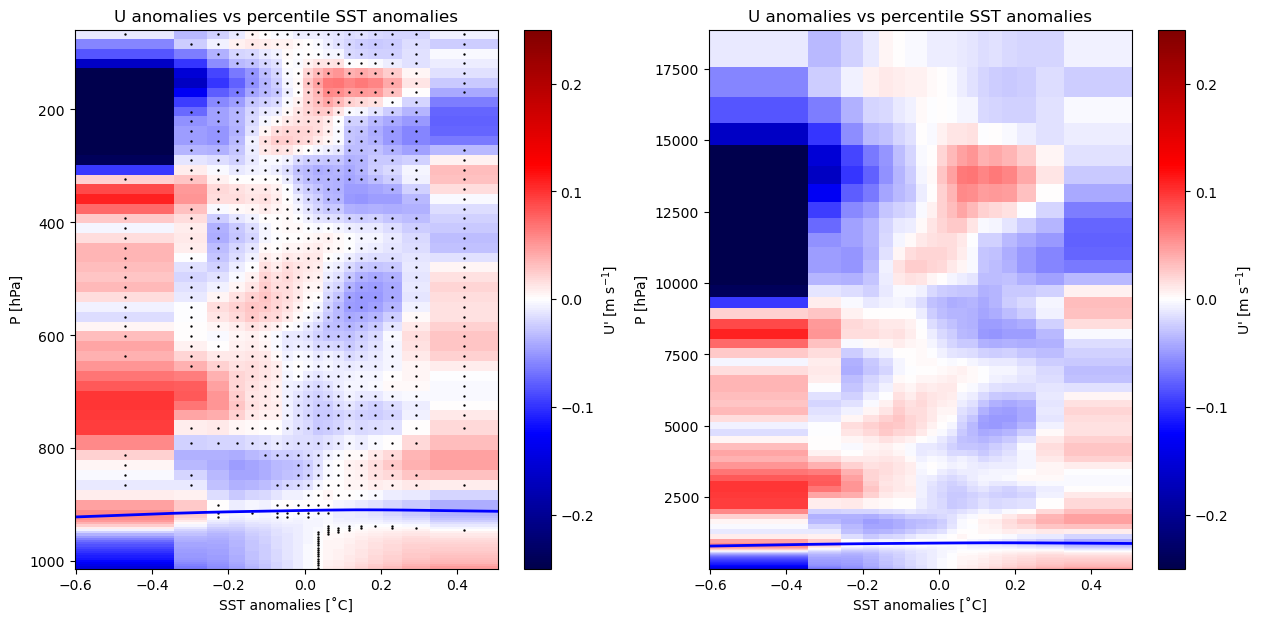

In [12]:
# figure PERC DIST dUtot vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'k'
plt.subplot(1,2,1)
plt.pcolormesh(pdist_dsst_day, GP, pdist_dUtot_dsst_day, vmin=-0.25, vmax=0.25, cmap='seismic')
plt.gca().invert_yaxis()
plt.title('U anomalies vs percentile SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label("U' [m s$^{-1}$]")
plt.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='b', linewidth=2)

# plt.scatter(dsstbin,signif,  s=0.5, color='k')
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.5, color='k')

plt.subplot(1,2,2)
plt.pcolormesh(pdist_dsst_day, GPH, pdist_dUtot_dsst_day, vmin=-0.25, vmax=0.25, cmap='seismic')
plt.title('U anomalies vs percentile SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label("U' [m s$^{-1}$]")
plt.plot(pdist_dsst_day, pdist_PBLH_dsst_day, '-', color='b', linewidth=2)

# plt.pcolormesh(pdist_dsst_day, GPH, pdist_dUtot_dsst_day, vmin=-0.25, vmax=0.25, cmap='seismic')

In [15]:
# # figure PERC DIST dUtot vs dSST bin - DAILY
# fig, ax1 = plt.subplots(figsize=(15, 7))

# color = 'k'
# plt.subplot(1,2,1)
# plt.pcolormesh(pdist_dsst_day, GP, pdist_dUtot_dsst_day, vmin=-0.25, vmax=0.25, cmap='seismic')
# plt.gca().invert_yaxis()
# plt.title('U anomalies vs percentile SST anomalies')
# plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
# cbar = plt.colorbar();  cbar.set_label("U' [m s$^{-1}$]")
# plt.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)

# plt.scatter(dsstbin,signif_Lcorr,  s=0.5, color='k')

# plt.subplot(1,2,2)
# plt.pcolormesh(pdist_dsst_day, GP, pdist_dUtot_dsst_day_Lcorr_H, vmin=-0.25, vmax=0.25, cmap='seismic')
# plt.gca().invert_yaxis()
# plt.title('U anomalies vs percentile SST anomalies')
# plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
# cbar = plt.colorbar();  cbar.set_label("U' [m s$^{-1}$]")
# plt.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)

# plt.scatter(dsstbin,signif_Lcorr_H,  s=0.5, color='k')

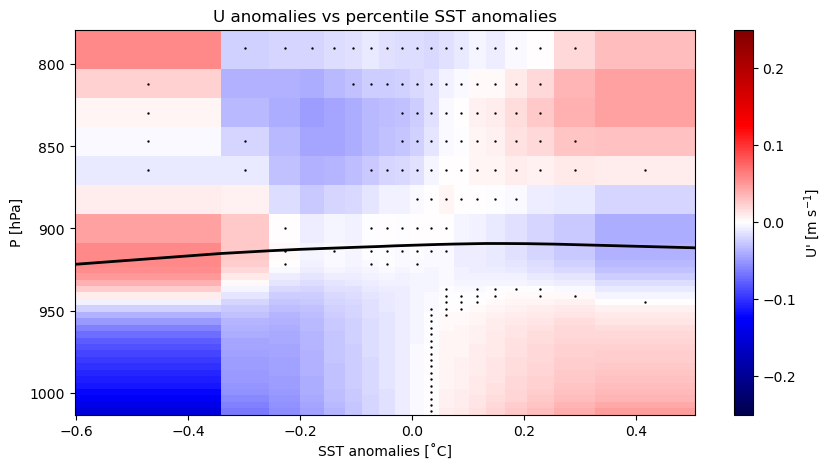

In [16]:
# figure PERC DIST dUtot vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))

level = 33
color = 'k'
plt.pcolormesh(pdist_dsst_day, GP[:level], pdist_dUtot_dsst_day[:level], vmin=-0.25, vmax=0.25, cmap='seismic')
plt.gca().invert_yaxis()
plt.title('U anomalies vs percentile SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label("U' [m s$^{-1}$]")
plt.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)

plt.scatter(dsstbin[:level-1], signif_Lcorr_H[:level-1],  s=0.5, color='k')

In [25]:
##############
# dQVAPOR
pdist_dsst_day = np.loadtxt(path_bindist + 'pdist_dsst_day.txt')
pdist_dqvapor_dsst_day = np.loadtxt(path_bindist + 'pdist_dQVAPOR_dsst_day.txt')
pstd_dqvapor_dsst_day = np.loadtxt(path_bindist + 'pstd_dQVAPOR_dsst_day.txt')
# pvalue_dqvapor_dsst_day = np.loadtxt(path_bindist_pvalue + 'pvalue_dQVAPOR_dsst_day_Lcorr30km-150km.txt')

In [201]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064.    # dof with Lcorr = 30km and Tcorr = 1day
doftop = 1826.  # dof with Lcorr = 150km and Tcorr = 1day
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = pdist_dqvapor_dsst_day
s2 = pstd_dqvapor_dsst_day**2.
pvalue_dqvapor_dsst_day = np.zeros(pdist_dqvapor_dsst_day.shape)
for h in range(0,pdist_dUtot_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_dqvapor_dsst_day[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dqvapor_dsst_day[np.isnan(pvalue_dqvapor_dsst_day)] = 999.

In [202]:
pdist_PBLH_dsst_day = np.loadtxt(path_bindist_fullfield + 'pdist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
pdist_P_dsst_day = height_to_pressure_std(pdist_PBLH_dsst_day*units.meter)

In [203]:
# # DEF punti significativi (pvalue < 0.5)
# GPbin = GP[1:] - np.diff(GP)*0.5
# signif = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# dsstbin = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# for h in range(0,len(GP)-1):
#     scra = np.repeat(GPbin[h],len(pdist_dsst_day)-1)
#     scra[pvalue_dqvapor_dsst_day[h,:-1] < 0.05] = np.nan
#     signif[h,:] = scra
#     dsstbin[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

In [204]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
dsstbin = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dqvapor_dsst_day[h,:-1] > 0.05
    cond2 = np.abs(pdist_dqvapor_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(pdist_dqvapor_dsst_day))
    cond = (cond1) | (cond2)
    signif[h,:] = np.zeros(len(pdist_dsst_day)-1) + np.nan
    signif[h, cond] = GPbin[h]
    dsstbin[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

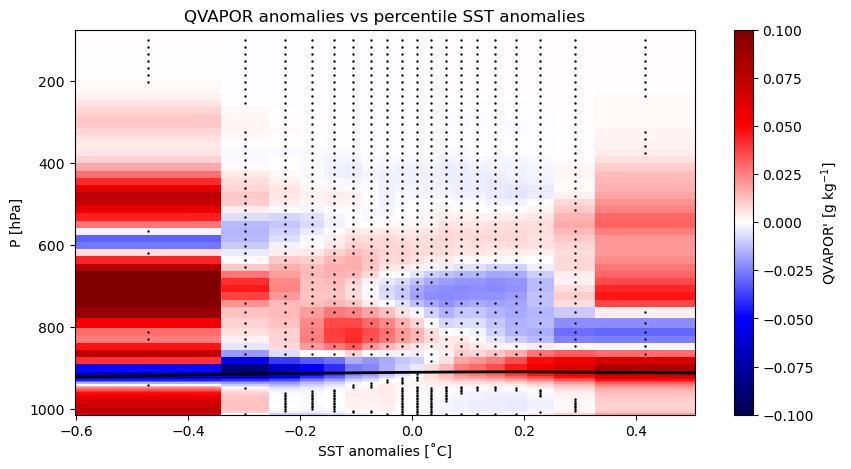

In [206]:
# figure PERC DIST dQVAPOR vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))

level = -1
color = 'k'
plt.pcolormesh(pdist_dsst_day, GP[:level], pdist_dqvapor_dsst_day[:level], vmin=-0.1, vmax=0.1, cmap='seismic')
plt.gca().invert_yaxis()
plt.title('QVAPOR anomalies vs percentile SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label("QVAPOR' [g kg$^{-1}$]")

plt.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)
plt.scatter(dsstbin[:level-1], signif[:level-1],  s=0.5, color='k')

# ax1.tick_params(axis='y', labelcolor=color)
# ax2 = ax1.twinx()  # second axes that shares the same x-axis
# ax2.spines["left"].set_position(("axes", -0.15))
# ax2.spines["left"].set_visible(True)
# ax2.yaxis.set_label_position('left')
# ax2.yaxis.set_ticks_position('left')
# ax2.set_ylim(GPH[0],GPH[-1])
# ax2.set_ylabel('height [m]', color=color)
# ax2.plot(pdist_dsst_day, pdist_PBLH_dsst_day, '-', color='k', linewidth=2)

In [19]:
##############
# dQCLOUD
pdist_dsst_day = np.loadtxt(path_bindist + 'pdist_dsst_day.txt')
pdist_dqcloud_dsst_day = np.loadtxt(path_bindist + 'pdist_dQCLOUD_dsst_day.txt')
pstd_dqcloud_dsst_day = np.loadtxt(path_bindist + 'pstd_dQCLOUD_dsst_day.txt')
pvalue_dqcloud_dsst_day_Lcorr = np.loadtxt(path_bindist_pvalue + 'pvalue_dQCLOUD_dsst_day_Lcorr30km-150km.txt')
# pvalue_dqcloud_dsst_day_Lcorr = np.loadtxt(path_bindist + 'pvalue_Lcorr/' + 'pvalue_dQCLOUD_dsst_day_Lcorr30km.txt')

In [20]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064.    # dof with Lcorr = 30km and Tcorr = 1day
doftop = 1826.  # dof with Lcorr = 150km and Tcorr = 1day
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = pdist_dqcloud_dsst_day
s2 = pstd_dqcloud_dsst_day**2.
pvalue_dqcloud_dsst_day_Lcorr = np.zeros(pdist_dqcloud_dsst_day.shape)
for h in range(0,pdist_dqcloud_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_dqcloud_dsst_day_Lcorr[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dqcloud_dsst_day_Lcorr[np.isnan(pvalue_dqcloud_dsst_day_Lcorr)] = 999.

In [21]:
pdist_PBLH_dsst_day = np.loadtxt(path_bindist_fullfield + 'pdist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
pdist_P_dsst_day = height_to_pressure_std(pdist_PBLH_dsst_day*units.meter)

In [21]:
# # DEF punti significativi (pvalue < 0.05)
# GPbin = GP[1:] - np.diff(GP)*0.5
# signif = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# signif_Lcorr = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# dsstbin = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# for h in range(0,len(GP)-1):
#     scra = np.repeat(GPbin[h],len(pdist_dsst_day)-1)
#     scra[pvalue_dqcloud_dsst_day_Lcorr[h,:-1] < 0.05] = np.nan
# #     scra[(pvalue_dqcloud_dsst_day_Lcorr[h,:-1] < 0.05) | (pdist_dqcloud_dsst_day[h,:-1] > np.nanmean(pdist_dqcloud_dsst_day))] = np.nan
# #     scra[pdist_dqcloud_dsst_day[h,:-1] > np.nanmean(pdist_dqcloud_dsst_day)] = np.nan
#     signif_Lcorr[h,:] = scra
#     dsstbin[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

In [32]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
dsstbin = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dqcloud_dsst_day_Lcorr[h,:-1] > 0.05
    cond2 = np.abs(pdist_dqcloud_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(pdist_dqcloud_dsst_day))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif[h,:] = np.zeros(len(pdist_dsst_day)-1) + np.nan
    signif[h, cond] = GPbin[h]
    dsstbin[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

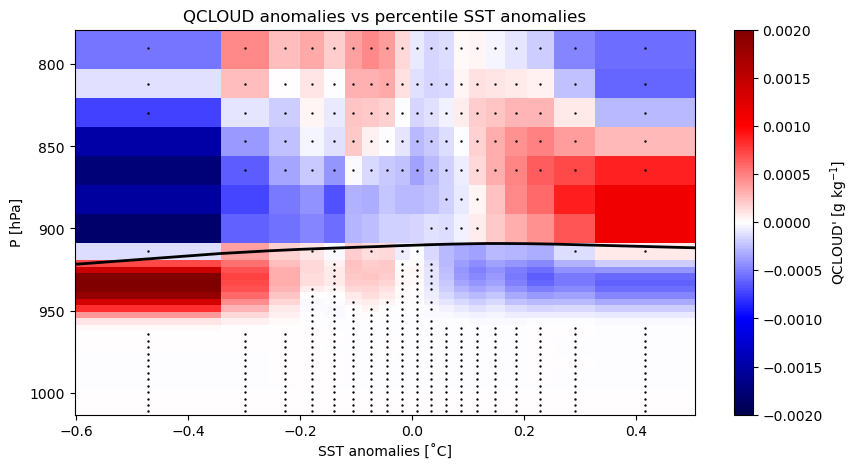

In [33]:
# figure PERC DIST dQCLOUD vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))

level = 33
color = 'k'
plt.pcolormesh(pdist_dsst_day, GP[:level], pdist_dqcloud_dsst_day[:level], vmin=-2e-3, vmax=2.e-3, cmap='seismic')
plt.gca().invert_yaxis()
plt.title('QCLOUD anomalies vs percentile SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label("QCLOUD' [g kg$^{-1}$]")

plt.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)
plt.scatter(dsstbin[:level-1], signif[:level-1],  s=0.5, color='k')

In [109]:
pvalue_dqcloud_dsst_day_Lcorr[12] 

array([2.60790975e-03, 1.00915764e-04, 6.79284180e-04, 1.69266362e-01,
       8.14020343e-01, 4.18885277e-01, 2.37358536e-01, 1.65107149e-01,
       1.17224798e-01, 1.36344463e-01, 6.71563986e-01, 3.86638337e-01,
       3.43846192e-01, 1.72301445e-01, 8.25424203e-03, 7.31843507e-04,
       5.29218735e-03, 3.00174537e-01, 1.22672983e-11, 0.00000000e+00])

In [114]:
0.1*np.nanmean(np.abs(pdist_dqcloud_dsst_day))

8.494605103064127e-06

In [110]:
signif_Lcorr[12]

array([         nan,          nan,          nan, 964.40814209,
       964.40814209, 964.40814209, 964.40814209, 964.40814209,
       964.40814209, 964.40814209, 964.40814209, 964.40814209,
       964.40814209, 964.40814209, 964.40814209, 964.40814209,
                nan, 964.40814209,          nan])

In [111]:
pdist_dqcloud_dsst_day[12]

array([ 2.06060964e-06,  2.94525881e-06,  2.98968726e-06,  9.13501017e-07,
        1.26259288e-07, -3.35696484e-07, -4.25780311e-07, -4.94117776e-07,
       -5.35575529e-07, -4.59677762e-07, -1.71086086e-07, -2.89403465e-07,
       -3.05915286e-07, -4.47919887e-07, -7.61070893e-07, -8.16000319e-07,
        2.18459010e-06,  5.16900015e-07, -1.65390178e-06, -2.80598719e-06])

In [24]:
pstd_dqcloud_dsst_day[4]

array([5.32469034e-10, 1.94457965e-09, 2.86648602e-09, 2.32014840e-06,
       3.57956680e-09, 3.69469351e-09, 3.59734310e-09, 3.59540194e-09,
       3.50513011e-09, 3.44532332e-09, 3.44086847e-09, 3.34653638e-09,
       3.26534309e-09, 3.19473432e-09, 3.23717104e-09, 2.84790549e-09,
       2.31201596e-09, 1.83055456e-09, 1.35997851e-09, 5.88538095e-10])

In [29]:
ttmp = pdist_dqcloud_dsst_day[4,0]/(np.sqrt(pstd_dqcloud_dsst_day[4,0]**2/dof))
ttmp

-6.438907659047557

In [44]:
pdist_dqcloud_dsst_day[4,:-1] > np.nanmean(pdist_dqcloud_dsst_day)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [45]:
pvalue_dqcloud_dsst_day_Lcorr[4,:-1] < 0.05

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [48]:
(pdist_dqcloud_dsst_day[4,:-1] > np.nanmean(pdist_dqcloud_dsst_day)) | (pvalue_dqcloud_dsst_day_Lcorr[4,:-1] < 0.05)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [187]:
##############
# dRH
pdist_dsst_day = np.loadtxt(path_bindist + 'pdist_dsst_day.txt')
pdist_drh_dsst_day = np.loadtxt(path_bindist + 'pdist_dRH_dsst_day.txt')
pstd_drh_dsst_day = np.loadtxt(path_bindist + 'pstd_dRH_dsst_day.txt')
pvalue_drh_dsst_day = np.loadtxt(path_bindist_pvalue + 'pvalue_dRH_dsst_day_Lcorr30km-150km.txt')

In [188]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064.    # dof with Lcorr = 30km and Tcorr = 1day
doftop = 1826.  # dof with Lcorr = 150km and Tcorr = 1day
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = pdist_drh_dsst_day
s2 = pstd_drh_dsst_day**2.
pvalue_drh_dsst_day = np.zeros(pdist_drh_dsst_day.shape)
for h in range(0,pdist_drh_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_drh_dsst_day[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_drh_dsst_day[np.isnan(pvalue_drh_dsst_day)] = 999.

In [189]:
pdist_PBLH_dsst_day = np.loadtxt(path_bindist_fullfield + 'pdist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
pdist_P_dsst_day = height_to_pressure_std(pdist_PBLH_dsst_day*units.meter)

In [190]:
# # DEF punti significativi (pvalue < 0.05)
# GPbin = GP[1:] - np.diff(GP)*0.5
# signif = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# dsstbin = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# for h in range(0,len(GP)-1):
#     scra = np.repeat(GPbin[h],len(pdist_dsst_day)-1)
#     scra[pvalue_drh_dsst_day[h,:-1] < 0.05] = np.nan
#     signif[h,:] = scra
#     dsstbin[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

In [191]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
dsstbin = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_drh_dsst_day[h,:-1] > 0.05
    cond2 = np.abs(pdist_drh_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(pdist_drh_dsst_day))
    cond = (cond1) | (cond2)
    signif[h,:] = np.zeros(len(pdist_dsst_day)-1) + np.nan
    signif[h, cond] = GPbin[h]
    dsstbin[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

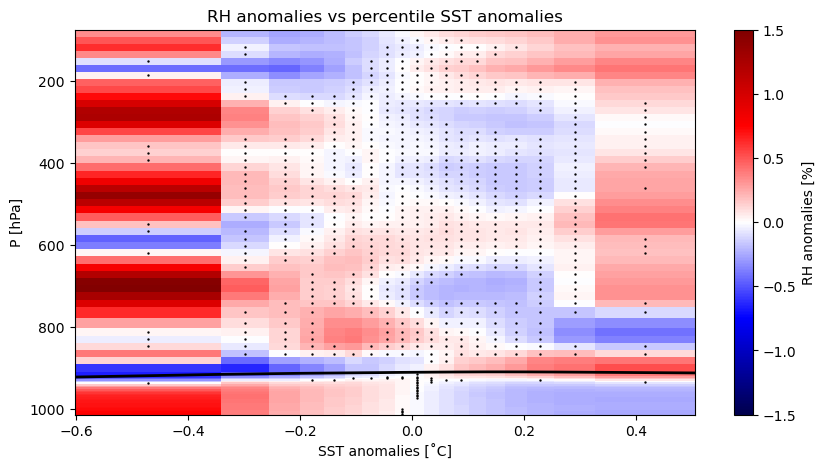

In [193]:
# figure dRH vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))

level = -1
color = 'k'
plt.pcolormesh(pdist_dsst_day, GP[:level], pdist_drh_dsst_day[:level], vmin=-1.5, vmax=1.5, cmap='seismic')
plt.gca().invert_yaxis()
plt.title('RH anomalies vs percentile SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label('RH anomalies [%]')

plt.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)
plt.scatter(dsstbin[:level-1], signif[:level-1],  s=0.5, color='k')

In [159]:
##############
# dN2 Brunt Vaisala
pdist_dsst_day = np.loadtxt(path_bindist + 'pdist_dsst_day.txt')
pdist_dN2_dsst_day = np.loadtxt(path_bindist + 'pdist_dN2_dsst_day.txt')
pstd_dN2_dsst_day = np.loadtxt(path_bindist + 'pstd_dN2_dsst_day.txt')
# pvalue_dN2_dsst_day = np.loadtxt(path_bindist_pvalue + 'pvalue_dN2_dsst_day_Lcorr30km-150km.txt')

In [174]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064.    # dof with Lcorr = 30km and Tcorr = 1day
doftop = 1826.  # dof with Lcorr = 150km and Tcorr = 1day
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = pdist_dN2_dsst_day
s2 = pstd_dN2_dsst_day**2.
pvalue_dN2_dsst_day = np.zeros(pdist_dN2_dsst_day.shape)
for h in range(0,pdist_dN2_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_dN2_dsst_day[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dN2_dsst_day[np.isnan(pvalue_dN2_dsst_day)] = 999.

In [175]:
pdist_PBLH_dsst_day = np.loadtxt(path_bindist_fullfield + 'pdist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
pdist_P_dsst_day = height_to_pressure_std(pdist_PBLH_dsst_day*units.meter)

In [167]:
# # DEF punti significativi (pvalue < 0.05)
# GPbin = GP[1:] - np.diff(GP)*0.5
# signif = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# dsstbin = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
# for h in range(0,len(GP)-1):
#     scra = np.repeat(GPbin[h],len(pdist_dsst_day)-1)
#     scra[pvalue_dN2_dsst_day[h,:-1] < 0.05] = np.nan
#     signif[h,:] = scra
#     dsstbin[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

In [178]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
dsstbin = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dN2_dsst_day[h,:-1] > 0.05
    cond2 = np.abs(pdist_dN2_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(pdist_dN2_dsst_day))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif[h,:] = np.zeros(len(pdist_dsst_day)-1) + np.nan
    signif[h, cond] = GPbin[h]
    dsstbin[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

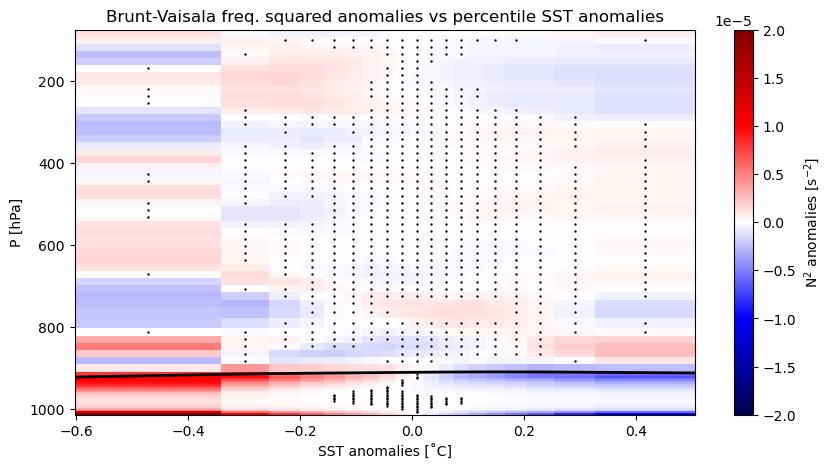

In [181]:
# figure dN2 vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))

level = -1
color = 'k'
plt.pcolormesh(pdist_dsst_day, GP[:level], pdist_dN2_dsst_day[:level], vmin=-2.e-5, vmax=2.e-5, cmap='seismic')
plt.gca().invert_yaxis()
plt.title('Brunt-Vaisala freq. squared anomalies vs percentile SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar(); cbar.set_label('N$^2$ anomalies [s$^{-2}$]')

plt.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)
plt.scatter(dsstbin[:level-1], signif[:level-1],  s=0.5, color='k')

In [ ]:
##############
##### FIXED BIN DISTRIBUTION

In [11]:
# dU
dist_dsst_day = np.loadtxt(path_fbindist + 'dist_dsst_day.txt')
dist_dUtot_dsst_day = np.loadtxt(path_fbindist + 'dist_dUtot_dsst_day.txt')
stderr_dUtot_dsst_day = np.loadtxt(path_fbindist + 'stderr_dUtot_dsst_day.txt')
npoint_dUtot_dsst_day = np.loadtxt(path_fbindist + 'npoint_dUtot_dsst_day.txt')
std_dUtot_dsst_day = stderr_dUtot_dsst_day*np.sqrt(npoint_dUtot_dsst_day)
del stderr_dUtot_dsst_day,npoint_dUtot_dsst_day

In [12]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
dof = 43064 
doftop = 1826
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = dist_dUtot_dsst_day
s2 = std_dUtot_dsst_day**2.
pvalue_dUtot_dsst_day_Lcorr_H = np.zeros(dist_dUtot_dsst_day.shape)
for h in range(0,dist_dUtot_dsst_day.shape[0]):
    tstat = m[h]/(np.sqrt(s2[h]/df[h]))
    pvalue_dUtot_dsst_day_Lcorr_H[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dUtot_dsst_day_Lcorr_H[np.isnan(pvalue_dUtot_dsst_day_Lcorr_H)] = 999.

In [13]:
dist_PBLH_dsst_day = np.loadtxt(path_fbindist_fullfield + 'dist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
dist_P_dsst_day = height_to_pressure_std(dist_PBLH_dsst_day*units.meter)

In [14]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif = np.zeros((len(GP)-1,len(dist_dsst_day)-1))
dsstbin = np.zeros((len(GP)-1,len(dist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dUtot_dsst_day_Lcorr_H[h,:-1] > 0.05
    cond2 = np.abs(dist_dUtot_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(dist_dUtot_dsst_day))
    cond = (cond1) | (cond2)
    signif[h,:] = np.zeros(len(dist_dsst_day)-1) + np.nan
    signif[h, cond] = GPbin[h]
    dsstbin[h,:] = dist_dsst_day[1:] - np.diff(dist_dsst_day)*0.5

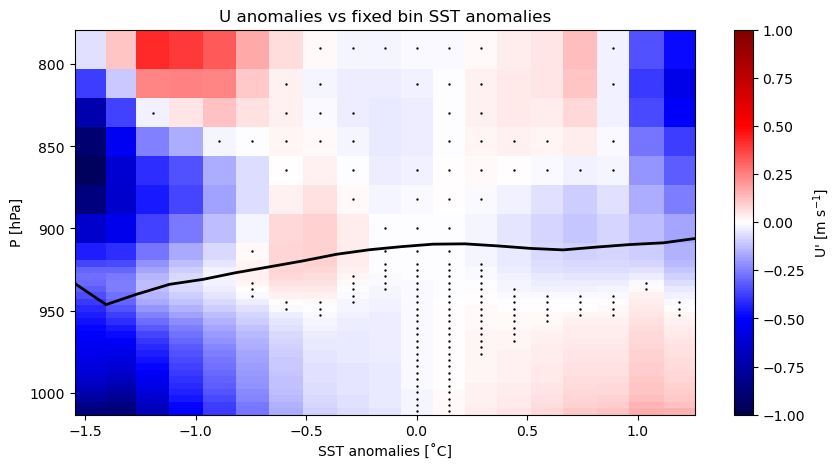

In [16]:
# figure FB DIST dUtot vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))

level = 33
color = 'k'
plt.pcolormesh(dist_dsst_day, GP[:level], dist_dUtot_dsst_day[:level], vmin=-1., vmax=1., cmap='seismic')
plt.gca().invert_yaxis()
plt.title('U anomalies vs fixed bin SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label("U' [m s$^{-1}$]")
plt.plot(dist_dsst_day, dist_P_dsst_day, '-', color='k', linewidth=2)

plt.scatter(dsstbin[:level-1], signif[:level-1],  s=0.5, color='k')

In [5]:
##############
# dQVAPOR
dist_dsst_day = np.loadtxt(path_fbindist + 'dist_dsst_day.txt')
dist_dqvapor_dsst_day = np.loadtxt(path_fbindist + 'dist_dQVAPOR_dsst_day.txt')
stderr_dqvapor_dsst_day = np.loadtxt(path_fbindist + 'stderr_dQVAPOR_dsst_day.txt')
npoint_dqvapor_dsst_day = np.loadtxt(path_fbindist + 'npoint_dQVAPOR_dsst_day.txt')
std_dqvapor_dsst_day = stderr_dqvapor_dsst_day*np.sqrt(npoint_dqvapor_dsst_day)
del stderr_dqvapor_dsst_day, npoint_dqvapor_dsst_day

In [6]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064.    # dof with Lcorr = 30km and Tcorr = 1day
doftop = 1826.  # dof with Lcorr = 150km and Tcorr = 1day
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = dist_dqvapor_dsst_day
s2 = std_dqvapor_dsst_day**2.
pvalue_dqvapor_dsst_day = np.zeros(dist_dqvapor_dsst_day.shape)
for h in range(0,dist_dqvapor_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_dqvapor_dsst_day[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dqvapor_dsst_day[np.isnan(pvalue_dqvapor_dsst_day)] = 999.

In [7]:
dist_PBLH_dsst_day = np.loadtxt(path_fbindist_fullfield + 'dist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
dist_P_dsst_day = height_to_pressure_std(dist_PBLH_dsst_day*units.meter)

In [8]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif = np.zeros((len(GP)-1,len(dist_dsst_day)-1))
dsstbin = np.zeros((len(GP)-1,len(dist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dqvapor_dsst_day[h,:-1] > 0.05
    cond2 = np.abs(dist_dqvapor_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(dist_dqvapor_dsst_day))
    cond = (cond1) | (cond2)
    signif[h,:] = np.zeros(len(dist_dsst_day)-1) + np.nan
    signif[h, cond] = GPbin[h]
    dsstbin[h,:] = dist_dsst_day[1:] - np.diff(dist_dsst_day)*0.5

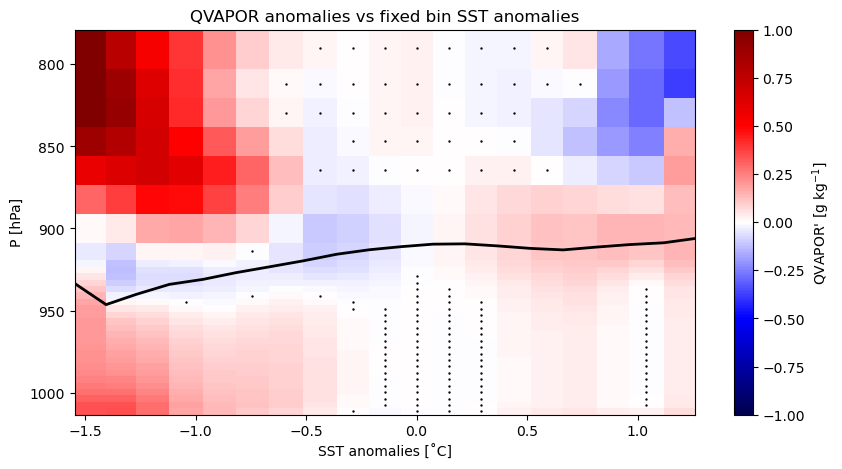

In [11]:
# figure FB DIST dQVAPOR vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))

level = 33
color = 'k'
plt.pcolormesh(dist_dsst_day, GP[:level], dist_dqvapor_dsst_day[:level], vmin=-1, vmax=1, cmap='seismic')
plt.gca().invert_yaxis()
plt.title('QVAPOR anomalies vs fixed bin SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label("QVAPOR' [g kg$^{-1}$]")

plt.plot(dist_dsst_day, dist_P_dsst_day, '-', color='k', linewidth=2)
plt.scatter(dsstbin[:level-1], signif[:level-1],  s=0.5, color='k')

In [44]:
# dQCLOUD
dist_dsst_day = np.loadtxt(path_fbindist + 'dist_dsst_day.txt')
dist_dQCLOUD_dsst_day = np.loadtxt(path_fbindist + 'dist_dQCLOUD_dsst_day.txt')
stderr_dQCLOUD_dsst_day = np.loadtxt(path_fbindist + 'stderr_dQCLOUD_dsst_day.txt')
npoint_dQCLOUD_dsst_day = np.loadtxt(path_fbindist + 'npoint_dQCLOUD_dsst_day.txt')
std_dQCLOUD_dsst_day = stderr_dQCLOUD_dsst_day*np.sqrt(npoint_dQCLOUD_dsst_day)
del stderr_dQCLOUD_dsst_day, npoint_dQCLOUD_dsst_day

In [45]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064.    # dof with Lcorr = 30km and Tcorr = 1day
doftop = 1826.  # dof with Lcorr = 150km and Tcorr = 1day
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = dist_dQCLOUD_dsst_day
s2 = std_dQCLOUD_dsst_day**2.
pvalue_dQCLOUD_dsst_day_Lcorr = np.zeros(dist_dQCLOUD_dsst_day.shape)
for h in range(0,dist_dQCLOUD_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_dQCLOUD_dsst_day_Lcorr[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dQCLOUD_dsst_day_Lcorr[np.isnan(pvalue_dQCLOUD_dsst_day_Lcorr)] = 999.

In [46]:
dist_PBLH_dsst_day = np.loadtxt(path_fbindist_fullfield + 'dist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
dist_P_dsst_day = height_to_pressure_std(dist_PBLH_dsst_day*units.meter)

In [47]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif = np.zeros((len(GP)-1,len(dist_dsst_day)-1))
dsstbin = np.zeros((len(GP)-1,len(dist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dQCLOUD_dsst_day_Lcorr[h,:-1] > 0.05
    cond2 = np.abs(dist_dQCLOUD_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(dist_dQCLOUD_dsst_day))
    cond = (cond1) | (cond2)
    signif[h,:] = np.zeros(len(dist_dsst_day)-1) + np.nan
    signif[h, cond] = GPbin[h]
    dsstbin[h,:] = dist_dsst_day[1:] - np.diff(dist_dsst_day)*0.5

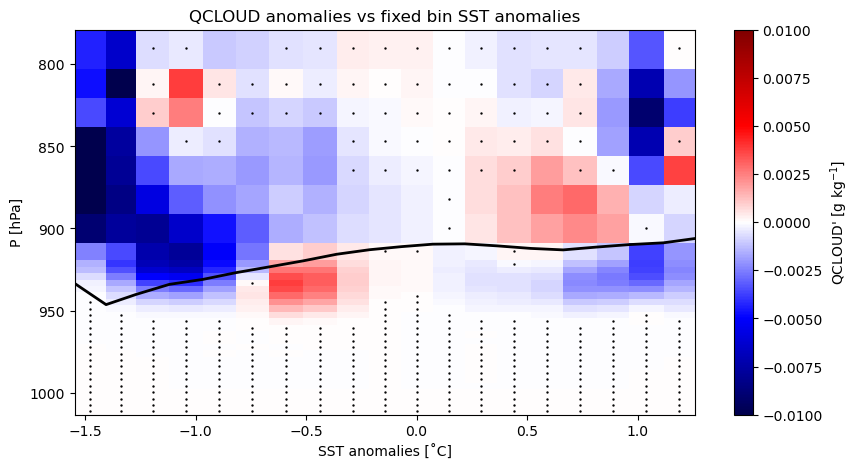

In [48]:
# figure FB DIST dQCLOUD vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))

level = 33
color = 'k'
plt.pcolormesh(dist_dsst_day, GP[:level], dist_dQCLOUD_dsst_day[:level], vmin=-1e-2, vmax=1.e-2, cmap='seismic')
plt.gca().invert_yaxis()
plt.title('QCLOUD anomalies vs fixed bin SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label("QCLOUD' [g kg$^{-1}$]")

plt.plot(dist_dsst_day, dist_P_dsst_day, '-', color='k', linewidth=2)

plt.scatter(dsstbin[:level-1], signif[:level-1],  s=0.5, color='k')

In [31]:
# dRH
dist_dsst_day = np.loadtxt(path_fbindist + 'dist_dsst_day.txt')
dist_dRH_dsst_day = np.loadtxt(path_fbindist + 'dist_dRH_dsst_day.txt')
stderr_dRH_dsst_day = np.loadtxt(path_fbindist + 'stderr_dRH_dsst_day.txt')
npoint_dRH_dsst_day = np.loadtxt(path_fbindist + 'npoint_dRH_dsst_day.txt')
std_dRH_dsst_day = stderr_dRH_dsst_day*np.sqrt(npoint_dRH_dsst_day)
del stderr_dRH_dsst_day,npoint_dRH_dsst_day

In [32]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064.    # dof with Lcorr = 30km and Tcorr = 1day
doftop = 1826.  # dof with Lcorr = 150km and Tcorr = 1day
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = dist_dRH_dsst_day
s2 = std_dRH_dsst_day**2.
pvalue_drh_dsst_day = np.zeros(dist_dRH_dsst_day.shape)
for h in range(0,dist_dRH_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_drh_dsst_day[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_drh_dsst_day[np.isnan(pvalue_drh_dsst_day)] = 999.

In [33]:
dist_PBLH_dsst_day = np.loadtxt(path_fbindist_fullfield + 'dist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
dist_P_dsst_day = height_to_pressure_std(dist_PBLH_dsst_day*units.meter)

In [34]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif = np.zeros((len(GP)-1,len(dist_dsst_day)-1))
dsstbin = np.zeros((len(GP)-1,len(dist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_drh_dsst_day[h,:-1] > 0.05
    cond2 = np.abs(dist_dRH_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(dist_dRH_dsst_day))
    cond = (cond1) | (cond2)
    signif[h,:] = np.zeros(len(dist_dsst_day)-1) + np.nan
    signif[h, cond] = GPbin[h]
    dsstbin[h,:] = dist_dsst_day[1:] - np.diff(dist_dsst_day)*0.5

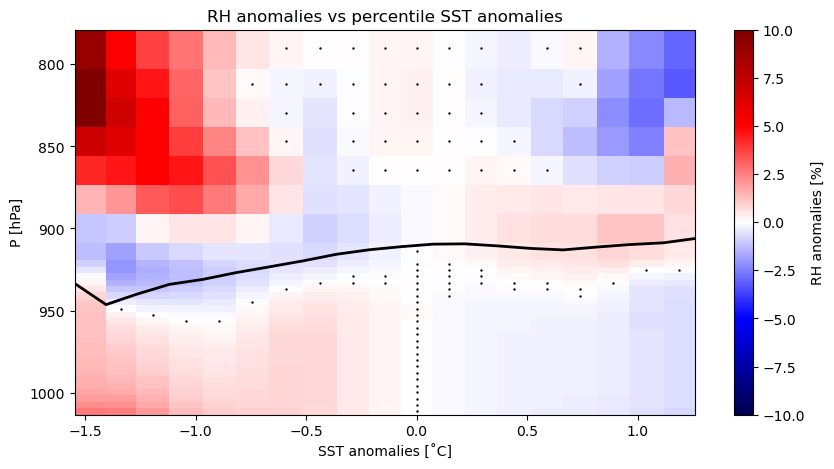

In [38]:
# figure FB DIST dRH vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))

level = 33
color = 'k'
plt.pcolormesh(dist_dsst_day, GP[:level], dist_dRH_dsst_day[:level], vmin=-10., vmax=10., cmap='seismic')
plt.gca().invert_yaxis()
plt.title('RH anomalies vs percentile SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label('RH anomalies [%]')

plt.plot(dist_dsst_day, dist_P_dsst_day, '-', color='k', linewidth=2)

plt.scatter(dsstbin[:level-1], signif[:level-1],  s=0.5, color='k')

In [56]:
# dN2
dist_dsst_day = np.loadtxt(path_fbindist + 'dist_dsst_day.txt')
dist_dN2_dsst_day = np.loadtxt(path_fbindist + 'dist_dN2_dsst_day.txt')
stderr_dN2_dsst_day = np.loadtxt(path_fbindist + 'stderr_dN2_dsst_day.txt')
npoint_dN2_dsst_day = np.loadtxt(path_fbindist + 'npoint_dN2_dsst_day.txt')
std_dN2_dsst_day = stderr_dN2_dsst_day*np.sqrt(npoint_dN2_dsst_day)
del stderr_dN2_dsst_day, npoint_dN2_dsst_day

In [57]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064.    # dof with Lcorr = 30km and Tcorr = 1day
doftop = 1826.  # dof with Lcorr = 150km and Tcorr = 1day
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = dist_dN2_dsst_day
s2 = std_dN2_dsst_day**2.
pvalue_dN2_dsst_day = np.zeros(dist_dN2_dsst_day.shape)
for h in range(0,dist_dN2_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_dN2_dsst_day[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dN2_dsst_day[np.isnan(pvalue_dN2_dsst_day)] = 999.

In [58]:
dist_PBLH_dsst_day = np.loadtxt(path_fbindist_fullfield + 'dist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
dist_P_dsst_day = height_to_pressure_std(dist_PBLH_dsst_day*units.meter)

In [59]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif = np.zeros((len(GP)-1,len(dist_dsst_day)-1))
dsstbin = np.zeros((len(GP)-1,len(dist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dN2_dsst_day[h,:-1] > 0.05
    cond2 = np.abs(dist_dN2_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(dist_dN2_dsst_day))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif[h,:] = np.zeros(len(dist_dsst_day)-1) + np.nan
    signif[h, cond] = GPbin[h]
    dsstbin[h,:] = dist_dsst_day[1:] - np.diff(dist_dsst_day)*0.5

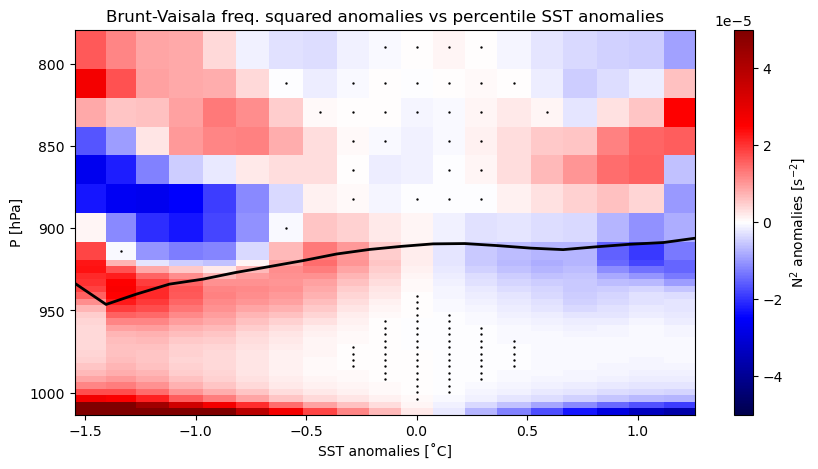

In [61]:
# figure FB DIST dN2 vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))

level = 33
color = 'k'
plt.pcolormesh(dist_dsst_day, GP[:level], dist_dN2_dsst_day[:level], vmin=-5.e-5, vmax=5.e-5, cmap='seismic')
plt.gca().invert_yaxis()
plt.title('Brunt-Vaisala freq. squared anomalies vs percentile SST anomalies')
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar(); cbar.set_label('N$^2$ anomalies [s$^{-2}$]')

plt.plot(dist_dsst_day, dist_P_dsst_day, '-', color='k', linewidth=2)

plt.scatter(dsstbin[:level-1], signif[:level-1],  s=0.5, color='k')